In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
import numpy as np
import torch
import torch.nn as nn
from facenet_pytorch import fixed_image_standardization
from torchvision import transforms
from tqdm import tqdm

from data_loader import get_loader, read_dataset, CompositeDataset
from model import FaceRecognitionCNN
from utils import write_json, copy_file, count_parameters
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)]))
    return torch.index_select(a, dim, order_index.to(device))

In [3]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

In [4]:
class Encoder2DTransformer(nn.Module):
    def __init__(self, face_recognition_cnn_path=None):
        super(Encoder2DTransformer, self).__init__()

        face_cnn = FaceRecognitionCNN()
        
        if face_recognition_cnn_path is not None:
            face_cnn = nn.DataParallel(face_cnn)
            state_dict = torch.load(face_recognition_cnn_path, map_location='cpu')
            face_cnn.load_state_dict(state_dict)

        if face_recognition_cnn_path:
            modules = list(face_cnn.module.resnet.children())[:-4]
            self.encoder2d = nn.Sequential(*modules)
            modules = list(face_cnn.module.resnet.children())[-4:-1]
            self.disc1 = nn.Sequential(*[Flatten(), *modules])
            self.disc2 = face_cnn.module.relu
            self.disc3 = face_cnn.module.dropout
            self.disc4 = nn.Linear(512, 1)

        else:
            modules = list(face_cnn.resnet.children())[:-4]
            self.encoder2d = nn.Sequential(*modules)
            modules = list(face_cnn.resnet.children())[-4:-1]
            self.disc1 = nn.Sequential(*[Flatten(), *modules])
            self.disc2 = face_cnn.relu
            self.disc3 = face_cnn.dropout
            self.disc4 = nn.Linear(512, 1)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=1792, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=4)
        self.fc = nn.Linear(1792, 5)
        self.relu = nn.ReLU()
    
    def forward(self, images):
        batch_size, num_channels, depth, height, width = images.shape
        images = images.permute(0, 2, 1, 3, 4)
        images = images.reshape(batch_size * depth, num_channels, height, width)
        out = self.encoder2d(images)
        side = self.disc1(out)
        side = self.disc2(side)
        side = self.disc3(side)
        side = self.disc4(side)
        out = out.reshape(batch_size, depth, 1792, 1, 1)
        out = out.squeeze(4)
        out = out.squeeze(3)
        out = out.permute(1, 0, 2)
        out = self.transformer_encoder(out)
        out = out.permute(1, 0, 2)
        out = out.index_select(1, torch.tensor([0]).to(device))
        out = out.squeeze()
        out = self.relu(out)
        out = self.fc(out)
        
        return  out, side

In [5]:
transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.RandomRotation(10),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomGrayscale(p=0.1),
        np.float32,
        transforms.ToTensor(),
        fixed_image_standardization
    ])

In [6]:
datasets = read_dataset(
    '../dataset/mtcnn/', transform=transform,
    max_images_per_video=11, max_videos=1000,
    window_size=11, splits_path='../dataset/splits/'
)
# only neural textures c40 and original c40
datasets = {
    k: v for k, v in datasets.items() 
    if ('original' in k or 'neural' in k or 'face2face' in k or 'faceswap' in k or 'deepfakes' in k) and 'c23' in k
}
print('Using training data: ')
print('\n'.join(sorted(datasets.keys())))

trains, vals, tests = [], [], []
for data_dir_name, dataset in datasets.items():
    train, val, test = dataset
    # repeat original data multiple times to balance out training data
    compression = data_dir_name.split('_')[-1]
    num_tampered_with_same_compression = len({x for x in datasets.keys() if compression in x}) - 1
    count = 1 if 'original' not in data_dir_name else num_tampered_with_same_compression
    for _ in range(count):
        trains.append(train)
    vals.append(val)
    tests.append(test)
    
train_dataset, val_dataset, test_dataset = CompositeDataset(*trains), CompositeDataset(*vals), CompositeDataset(*tests)

['deepfakes_faces_c23', 'original_faces_c23', 'face2face_faces_c23', 'neural_textures_faces_c23', 'faceswap_faces_c23']
Using training data: 
deepfakes_faces_c23
face2face_faces_c23
faceswap_faces_c23
neural_textures_faces_c23
original_faces_c23


In [7]:
tqdm.write('train data size: {}, validation data size: {}'.format(len(train_dataset), len(val_dataset)))

train data size: 63320, validation data size: 7675


In [8]:
train_loader = get_loader(
    train_dataset, 64, shuffle=True, num_workers=2
)
val_loader = get_loader(
    val_dataset, 64, shuffle=True, num_workers=2
)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('training on', device)
[device]

training on cuda


[device(type='cuda')]

In [10]:
model = Encoder2DTransformer('./model/facenet/model.pt')
#model = Encoder2DTransformer()
model = nn.DataParallel(model)
model.to(device)
#if args.freeze_first_epoch:
#for m in model.resnet.parameters():
#    m.requires_grad_(False)

DataParallel(
  (module): Encoder2DTransformer(
    (encoder2d): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001

In [11]:
input_shape = next(iter(train_loader))[2].shape
print('input shape', input_shape)
# need to call this before summary!!!
model.eval()
# summary(model, input_shape[1:], batch_size=input_shape[0], device=device)
print('model params (trainable, total):', count_parameters(model))

input shape torch.Size([64, 3, 11, 160, 160])
model params (trainable, total): (124508422, 124508422)


In [12]:
criterion = nn.CrossEntropyLoss(weight = torch.Tensor([0.8, 0.5, 0.5, 0.5, 0.5]).to(device)) 
criterion_side = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-5, weight_decay=1e-3
)

# decrease learning rate if validation accuracy has not increased
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=1/4, patience=2, verbose=True,
)

In [13]:
def save_model_checkpoint(epoch, model, val_acc):
    
    model_dir = os.path.join('./model', 'enctrf2loss')
    os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_dir, f'model.pt')
    torch.save(model.state_dict(), model_path)

    model_info = {
        'epoch': epoch,
        'val_acc': val_acc[0],
        'model_str': str(model)
    }
    json_path = os.path.join(model_dir, 'info.json')
    write_json(model_info, json_path)

    #src_model_file = os.path.join('facenet', 'model.py')
    #dest_model_file = os.path.join(model_dir, 'model.py')
    #copy_file(src_model_file, dest_model_file)

    tqdm.write(f'New checkpoint saved at {model_path}')


def print_training_info(batch_accuracy, loss, step):
    log_info = 'Training - Loss: {:.4f}, Accuracy: {:.4f}'.format(loss.item(), batch_accuracy)
    tqdm.write(log_info)

    #writer.add_scalar('training loss', loss.item(), step)
    #writer.add_scalar('training acc', batch_accuracy, step)


def print_validation_info(criterion, device, model, val_loader, epoch, step):
    model.eval()
    with torch.no_grad():
        loss_values = []
        all_predictions = []
        all_targets = []
        targets = []
        outputs = []
        for video_ids, frame_ids, images, target in val_loader:
            images = images.to(device)
            target = target.to(device)
            target = target.long()
            output, _ = model(images)
            loss = criterion(output, target)
            loss_values.append(loss.item())
            targets.append(target)
            outputs.append(output)
            #predictions = outputs > 0.0
            #all_predictions.append(predictions)
            #all_targets.append(targets)
            #if args.debug:
            #    tqdm.write(outputs)
            #    tqdm.write(predictions)
            #    tqdm.write(targets)
        
        val_loss = sum(loss_values) / len(loss_values)
        
        outputs = torch.cat(outputs, 0)
        targets = torch.cat(targets, 0)
        
        val_accuracy = float((outputs.argmax(1)).eq(targets).sum()) / len(targets)
        
        total_target = targets.unique(return_counts=True)[1]
        pristine = ((outputs.argmax(1) == 0) * (targets == 0)).sum() / total_target[0]
        face2face = ((outputs.argmax(1) == 1) * (targets == 1)).sum() / total_target[1]
        faceswap = ((outputs.argmax(1) == 2) * (targets == 2)).sum() / total_target[2]
        neural = ((outputs.argmax(1) == 3) * (targets == 3)).sum() / total_target[3]
        deepfake = ((outputs.argmax(1) == 4) * (targets == 4)).sum() / total_target[4]
        
        tqdm.write(
            'Validation - Loss: {:.3f}, Acc: {:.3f}, Pr: {:.3f}, Ff: {:.3f}, Fs: {:.3f}, Nt: {:.3f}, Df: {:.3f}'.format(
                val_loss, val_accuracy, pristine, face2face, faceswap, neural, deepfake
            )
        )
        
    return val_accuracy, pristine, face2face, faceswap, neural, deepfake

In [14]:
total_step = len(train_loader)
step = 1
best_val_acc = 0.5
for epoch in range(10):
    for i, (video_ids, frame_ids, images, targets) in \
            tqdm(enumerate(train_loader), desc=f'training epoch {epoch}', total=len(train_loader)):
        model.train()
        # Set mini-batch dataset
        images = images.to(device)
        targets = targets.to(device)

        # Forward, backward and optimize
        outputs, sides = model(images)
        targets = targets.long()
        tiled_targets = tile(targets, 0, 11)
        side_targets = (tiled_targets == 0).unsqueeze(1).float()
        loss = criterion(outputs, targets)
        loss_side = criterion_side(sides, side_targets)
        model.zero_grad()
        if i % 2 == 0:
            loss.backward()
        else:
            loss_side.backward()
        optimizer.step()

        batch_accuracy = float((outputs.argmax(1)).eq(targets).sum()) / len(targets)
        
        

        # Print log info
        step += 1
        
        if (i + 1) % 300 == 0:
            print_training_info(batch_accuracy, loss, step)

        if (i + 1) % 300 == 0:
            val_acc, pr_acc, ff_acc, fs_acc, nt_acc, df_acc = print_validation_info(
                criterion, device, model, val_loader, epoch, step
            )
            if val_acc > best_val_acc:
                save_model_checkpoint(epoch, model, (val_acc, pr_acc, ff_acc, fs_acc, nt_acc, df_acc))
                best_val_acc = val_acc

    # validation step after full epoch
    val_acc, pr_acc, ff_acc, fs_acc, nt_acc, df_acc = print_validation_info(
        criterion, device, model, val_loader, epoch, step
    )
    lr_scheduler.step(val_acc)
    if val_acc > best_val_acc:
        save_model_checkpoint(epoch, model, (val_acc, pr_acc, ff_acc, fs_acc, nt_acc, df_acc))
        best_val_acc = val_acc

#    if epoch == 0:
#        for m in model.resnet.parameters():
#            m.requires_grad_(True)
#        tqdm.write('Fine tuning on')

training epoch 0:  30%|███       | 299/989 [04:22<09:17,  1.24it/s]

Training - Loss: 0.1163, Accuracy: 0.9688


training epoch 0:  30%|███       | 299/989 [06:13<09:17,  1.24it/s]

Validation - Loss: 0.718, Acc: 0.791, Pr: 0.900, Ff: 0.787, Fs: 0.913, Nt: 0.504, Df: 0.851


training epoch 0:  30%|███       | 300/989 [06:21<6:59:15, 36.51s/it]

New checkpoint saved at ./model/enctrf2loss/model.pt


training epoch 0:  61%|██████    | 599/989 [10:30<05:58,  1.09it/s]  

Training - Loss: 0.0701, Accuracy: 0.9688


training epoch 0:  61%|██████    | 599/989 [12:17<05:58,  1.09it/s]

Validation - Loss: 0.713, Acc: 0.801, Pr: 0.823, Ff: 0.844, Fs: 0.786, Nt: 0.628, Df: 0.922


training epoch 0:  61%|██████    | 600/989 [12:24<3:46:13, 34.89s/it]

New checkpoint saved at ./model/enctrf2loss/model.pt


training epoch 0:  91%|█████████ | 899/989 [16:32<01:11,  1.26it/s]  

Training - Loss: 0.1570, Accuracy: 0.9688


training epoch 0:  91%|█████████ | 899/989 [18:18<01:11,  1.26it/s]

Validation - Loss: 0.757, Acc: 0.814, Pr: 0.612, Ff: 0.873, Fs: 0.922, Nt: 0.738, Df: 0.926


training epoch 0:  91%|█████████ | 900/989 [18:24<50:56, 34.34s/it]

New checkpoint saved at ./model/enctrf2loss/model.pt


training epoch 0: 100%|██████████| 989/989 [19:37<00:00,  1.19s/it]


Validation - Loss: 0.722, Acc: 0.813, Pr: 0.707, Ff: 0.924, Fs: 0.902, Nt: 0.629, Df: 0.902


training epoch 1:  30%|███       | 299/989 [04:28<10:21,  1.11it/s]

Training - Loss: 0.1134, Accuracy: 0.9375


training epoch 1:  30%|███       | 299/989 [06:21<10:21,  1.11it/s]

Validation - Loss: 0.793, Acc: 0.821, Pr: 0.645, Ff: 0.846, Fs: 0.932, Nt: 0.759, Df: 0.923


training epoch 1:  30%|███       | 300/989 [06:27<7:01:58, 36.75s/it]

New checkpoint saved at ./model/enctrf2loss/model.pt


training epoch 1:  61%|██████    | 599/989 [10:49<05:37,  1.16it/s]  

Training - Loss: 0.0207, Accuracy: 1.0000


training epoch 1:  61%|██████    | 600/989 [12:39<3:40:16, 33.98s/it]

Validation - Loss: 0.759, Acc: 0.816, Pr: 0.806, Ff: 0.886, Fs: 0.913, Nt: 0.525, Df: 0.947


training epoch 1:  91%|█████████ | 899/989 [17:00<01:25,  1.06it/s]  

Training - Loss: 0.0872, Accuracy: 0.9688


training epoch 1:  91%|█████████ | 899/989 [18:54<01:25,  1.06it/s]

Validation - Loss: 0.688, Acc: 0.833, Pr: 0.774, Ff: 0.839, Fs: 0.902, Nt: 0.740, Df: 0.909


training epoch 1:  91%|█████████ | 900/989 [19:00<54:33, 36.78s/it]

New checkpoint saved at ./model/enctrf2loss/model.pt


training epoch 1: 100%|██████████| 989/989 [20:14<00:00,  1.23s/it]


Validation - Loss: 0.815, Acc: 0.816, Pr: 0.711, Ff: 0.912, Fs: 0.862, Nt: 0.722, Df: 0.874


training epoch 2:  30%|███       | 299/989 [04:31<10:49,  1.06it/s]

Training - Loss: 0.0029, Accuracy: 1.0000


training epoch 2:  30%|███       | 300/989 [06:20<6:25:28, 33.57s/it]

Validation - Loss: 0.762, Acc: 0.831, Pr: 0.717, Ff: 0.885, Fs: 0.932, Nt: 0.740, Df: 0.881


training epoch 2:  61%|██████    | 599/989 [10:49<05:33,  1.17it/s]  

Training - Loss: 0.0100, Accuracy: 1.0000


training epoch 2:  61%|██████    | 599/989 [12:40<05:33,  1.17it/s]

Validation - Loss: 0.694, Acc: 0.843, Pr: 0.697, Ff: 0.846, Fs: 0.953, Nt: 0.808, Df: 0.911


training epoch 2:  61%|██████    | 600/989 [12:46<3:55:27, 36.32s/it]

New checkpoint saved at ./model/enctrf2loss/model.pt


training epoch 2:  91%|█████████ | 899/989 [17:13<01:25,  1.05it/s]  

Training - Loss: 0.0723, Accuracy: 0.9844


training epoch 2:  91%|█████████ | 900/989 [19:00<48:50, 32.93s/it]

Validation - Loss: 0.709, Acc: 0.837, Pr: 0.713, Ff: 0.827, Fs: 0.953, Nt: 0.742, Df: 0.947


training epoch 2: 100%|██████████| 989/989 [20:19<00:00,  1.23s/it]


Validation - Loss: 0.855, Acc: 0.820, Pr: 0.675, Ff: 0.936, Fs: 0.966, Nt: 0.602, Df: 0.919


training epoch 3:  30%|███       | 299/989 [04:31<10:43,  1.07it/s]

Training - Loss: 0.0016, Accuracy: 1.0000


training epoch 3:  30%|███       | 300/989 [06:24<6:37:31, 34.62s/it]

Validation - Loss: 0.738, Acc: 0.842, Pr: 0.719, Ff: 0.917, Fs: 0.933, Nt: 0.717, Df: 0.926


training epoch 3:  61%|██████    | 599/989 [10:49<05:49,  1.12it/s]  

Training - Loss: 0.0369, Accuracy: 0.9844


training epoch 3:  61%|██████    | 599/989 [12:40<05:49,  1.12it/s]

Validation - Loss: 0.693, Acc: 0.846, Pr: 0.757, Ff: 0.829, Fs: 0.942, Nt: 0.746, Df: 0.954


training epoch 3:  61%|██████    | 600/989 [12:46<3:53:44, 36.05s/it]

New checkpoint saved at ./model/enctrf2loss/model.pt


training epoch 3:  91%|█████████ | 899/989 [17:12<01:16,  1.18it/s]  

Training - Loss: 0.0758, Accuracy: 0.9688


training epoch 3:  91%|█████████ | 899/989 [19:06<01:16,  1.18it/s]

Validation - Loss: 0.671, Acc: 0.852, Pr: 0.775, Ff: 0.898, Fs: 0.959, Nt: 0.706, Df: 0.924


training epoch 3:  91%|█████████ | 900/989 [19:12<54:50, 36.97s/it]

New checkpoint saved at ./model/enctrf2loss/model.pt


training epoch 3: 100%|██████████| 989/989 [20:29<00:00,  1.24s/it]


Validation - Loss: 0.838, Acc: 0.837, Pr: 0.729, Ff: 0.931, Fs: 0.927, Nt: 0.705, Df: 0.892


training epoch 4:  30%|███       | 299/989 [04:22<09:21,  1.23it/s]

Training - Loss: 0.0077, Accuracy: 1.0000


training epoch 4:  30%|███       | 300/989 [06:16<6:42:24, 35.04s/it]

Validation - Loss: 0.755, Acc: 0.843, Pr: 0.725, Ff: 0.853, Fs: 0.934, Nt: 0.809, Df: 0.892


training epoch 4:  61%|██████    | 599/989 [10:33<05:08,  1.26it/s]  

Training - Loss: 0.0207, Accuracy: 0.9844


training epoch 4:  61%|██████    | 600/989 [12:26<3:45:53, 34.84s/it]

Validation - Loss: 0.792, Acc: 0.843, Pr: 0.702, Ff: 0.893, Fs: 0.957, Nt: 0.756, Df: 0.907


training epoch 4:  91%|█████████ | 899/989 [16:49<01:24,  1.06it/s]  

Training - Loss: 0.0036, Accuracy: 1.0000


training epoch 4:  91%|█████████ | 900/989 [18:43<51:38, 34.81s/it]

Validation - Loss: 0.787, Acc: 0.839, Pr: 0.701, Ff: 0.883, Fs: 0.965, Nt: 0.786, Df: 0.860


training epoch 4: 100%|██████████| 989/989 [19:59<00:00,  1.21s/it]


Validation - Loss: 0.885, Acc: 0.820, Pr: 0.671, Ff: 0.946, Fs: 0.930, Nt: 0.647, Df: 0.905


training epoch 5:  30%|███       | 299/989 [04:25<10:48,  1.06it/s]

Training - Loss: 0.0088, Accuracy: 1.0000


training epoch 5:  30%|███       | 300/989 [06:12<6:18:22, 32.95s/it]

Validation - Loss: 0.689, Acc: 0.846, Pr: 0.717, Ff: 0.883, Fs: 0.946, Nt: 0.739, Df: 0.945


training epoch 5:  61%|██████    | 599/989 [10:31<05:34,  1.16it/s]  

Training - Loss: 0.0017, Accuracy: 1.0000


training epoch 5:  61%|██████    | 600/989 [12:22<3:40:20, 33.98s/it]

Validation - Loss: 0.730, Acc: 0.845, Pr: 0.731, Ff: 0.888, Fs: 0.932, Nt: 0.761, Df: 0.913


training epoch 5:  91%|█████████ | 899/989 [16:42<01:25,  1.06it/s]  

Training - Loss: 0.0029, Accuracy: 1.0000


training epoch 5:  91%|█████████ | 900/989 [18:37<52:27, 35.36s/it]

Validation - Loss: 0.903, Acc: 0.822, Pr: 0.641, Ff: 0.878, Fs: 0.946, Nt: 0.828, Df: 0.815


training epoch 5: 100%|██████████| 989/989 [19:54<00:00,  1.21s/it]


Validation - Loss: 0.761, Acc: 0.840, Pr: 0.714, Ff: 0.909, Fs: 0.945, Nt: 0.730, Df: 0.904


training epoch 6:  30%|███       | 299/989 [04:36<11:23,  1.01it/s]

Training - Loss: 0.0373, Accuracy: 0.9844


training epoch 6:  30%|███       | 300/989 [06:28<6:37:48, 34.64s/it]

Validation - Loss: 0.698, Acc: 0.841, Pr: 0.805, Ff: 0.871, Fs: 0.892, Nt: 0.682, Df: 0.953


training epoch 6:  61%|██████    | 599/989 [10:54<06:38,  1.02s/it]  

Training - Loss: 0.0048, Accuracy: 1.0000


training epoch 6:  61%|██████    | 600/989 [12:50<3:51:41, 35.74s/it]

Validation - Loss: 0.747, Acc: 0.848, Pr: 0.742, Ff: 0.915, Fs: 0.929, Nt: 0.749, Df: 0.903


training epoch 6:  91%|█████████ | 899/989 [17:20<01:18,  1.14it/s]  

Training - Loss: 0.0046, Accuracy: 1.0000


training epoch 6:  91%|█████████ | 900/989 [19:09<50:02, 33.74s/it]

Validation - Loss: 0.702, Acc: 0.851, Pr: 0.704, Ff: 0.886, Fs: 0.948, Nt: 0.772, Df: 0.945


training epoch 6: 100%|██████████| 989/989 [20:28<00:00,  1.24s/it]


Validation - Loss: 0.748, Acc: 0.844, Pr: 0.680, Ff: 0.861, Fs: 0.934, Nt: 0.821, Df: 0.925


training epoch 7:  30%|███       | 299/989 [04:37<09:58,  1.15it/s]

Training - Loss: 0.1144, Accuracy: 0.9688


training epoch 7:  30%|███       | 300/989 [06:27<6:30:44, 34.03s/it]

Validation - Loss: 0.704, Acc: 0.847, Pr: 0.714, Ff: 0.906, Fs: 0.937, Nt: 0.748, Df: 0.930


training epoch 7:  61%|██████    | 599/989 [10:52<05:56,  1.09it/s]  

Training - Loss: 0.0011, Accuracy: 1.0000


training epoch 7:  61%|██████    | 599/989 [12:43<05:56,  1.09it/s]

Validation - Loss: 0.686, Acc: 0.855, Pr: 0.711, Ff: 0.889, Fs: 0.966, Nt: 0.762, Df: 0.947


training epoch 7:  61%|██████    | 600/989 [12:50<3:55:35, 36.34s/it]

New checkpoint saved at ./model/enctrf2loss/model.pt


training epoch 7:  91%|█████████ | 899/989 [17:05<01:15,  1.19it/s]  

Training - Loss: 0.0036, Accuracy: 1.0000


training epoch 7:  91%|█████████ | 900/989 [19:03<53:22, 35.98s/it]

Validation - Loss: 0.662, Acc: 0.848, Pr: 0.761, Ff: 0.914, Fs: 0.905, Nt: 0.733, Df: 0.926


training epoch 7: 100%|██████████| 989/989 [20:19<00:00,  1.23s/it]


Validation - Loss: 0.717, Acc: 0.838, Pr: 0.768, Ff: 0.710, Fs: 0.942, Nt: 0.834, Df: 0.938


training epoch 8:  30%|███       | 299/989 [04:28<11:13,  1.02it/s]

Training - Loss: 0.0032, Accuracy: 1.0000


training epoch 8:  30%|███       | 300/989 [06:11<6:07:04, 31.97s/it]

Validation - Loss: 0.815, Acc: 0.847, Pr: 0.674, Ff: 0.863, Fs: 0.956, Nt: 0.864, Df: 0.878


training epoch 8:  61%|██████    | 599/989 [10:35<06:19,  1.03it/s]  

Training - Loss: 0.0009, Accuracy: 1.0000


training epoch 8:  61%|██████    | 600/989 [12:20<3:29:29, 32.31s/it]

Validation - Loss: 0.689, Acc: 0.854, Pr: 0.727, Ff: 0.863, Fs: 0.949, Nt: 0.804, Df: 0.929


training epoch 8:  91%|█████████ | 899/989 [16:43<01:20,  1.11it/s]  

Training - Loss: 0.0017, Accuracy: 1.0000


training epoch 8:  91%|█████████ | 899/989 [18:34<01:20,  1.11it/s]

Validation - Loss: 0.648, Acc: 0.860, Pr: 0.731, Ff: 0.884, Fs: 0.957, Nt: 0.796, Df: 0.934


training epoch 8:  91%|█████████ | 900/989 [18:41<53:54, 36.34s/it]

New checkpoint saved at ./model/enctrf2loss/model.pt


training epoch 8: 100%|██████████| 989/989 [19:58<00:00,  1.21s/it]


Validation - Loss: 0.650, Acc: 0.850, Pr: 0.787, Ff: 0.918, Fs: 0.942, Nt: 0.670, Df: 0.935


training epoch 9:  30%|███       | 299/989 [04:23<10:10,  1.13it/s]

Training - Loss: 0.0012, Accuracy: 1.0000


training epoch 9:  30%|███       | 300/989 [06:15<6:34:48, 34.38s/it]

Validation - Loss: 0.742, Acc: 0.849, Pr: 0.671, Ff: 0.913, Fs: 0.940, Nt: 0.800, Df: 0.920


training epoch 9:  61%|██████    | 599/989 [10:34<05:35,  1.16it/s]  

Training - Loss: 0.0040, Accuracy: 1.0000


training epoch 9:  61%|██████    | 600/989 [12:26<3:43:18, 34.44s/it]

Validation - Loss: 0.762, Acc: 0.834, Pr: 0.812, Ff: 0.885, Fs: 0.862, Nt: 0.704, Df: 0.909


training epoch 9:  91%|█████████ | 899/989 [16:52<01:13,  1.23it/s]  

Training - Loss: 0.0173, Accuracy: 0.9844


training epoch 9:  91%|█████████ | 900/989 [18:45<51:28, 34.70s/it]

Validation - Loss: 0.831, Acc: 0.836, Pr: 0.703, Ff: 0.922, Fs: 0.892, Nt: 0.780, Df: 0.886


training epoch 9: 100%|██████████| 989/989 [20:01<00:00,  1.22s/it]


Validation - Loss: 0.672, Acc: 0.856, Pr: 0.758, Ff: 0.880, Fs: 0.927, Nt: 0.779, Df: 0.937


In [15]:
model = Encoder2DTransformer()
model = nn.DataParallel(model)
state_dict = torch.load('./model/enctrf2loss/model.pt', map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

test_loader = get_loader(
    test_dataset, 32, shuffle=True, num_workers=2, drop_last=False
)
with torch.no_grad():
    loss_values = []
    all_predictions = []
    all_targets = []
    targets = []
    outputs = []
    for video_ids, frame_ids, images, target in tqdm(test_loader):
        images = images.to(device)
        target = target.to(device)
        target = target.long()
        output, _ = model(images)
        targets.append(target)
        outputs.append(output)
        loss = criterion(output, target)
        loss_values.append(loss.item())

#                 predictions = outputs > 0.0
#                 all_predictions.append(predictions)
#                 all_targets.append(targets)

    val_loss = sum(loss_values) / len(loss_values)

    outputs = torch.cat(outputs, 0)
    targets = torch.cat(targets, 0)
        
    val_accuracy = float((outputs.argmax(1)).eq(targets).sum()) / len(targets)

    total_target = targets.unique(return_counts=True)[1]
    pristine = ((outputs.argmax(1) == 0) * (targets == 0)).sum() / total_target[0]
    face2face = ((outputs.argmax(1) == 1) * (targets == 1)).sum() / total_target[1]
    faceswap = ((outputs.argmax(1) == 2) * (targets == 2)).sum() / total_target[2]
    neural = ((outputs.argmax(1) == 3) * (targets == 3)).sum() / total_target[3]
    deepfake = ((outputs.argmax(1) == 4) * (targets == 4)).sum() / total_target[4]
    tqdm.write(
        'Test - Loss: {:.3f}, Acc: {:.3f}, Pr: {:.3f}, Ff: {:.3f}, Fs: {:.3f}, Nt: {:.3f}, Df: {:.3f}'.format(
            val_loss, val_accuracy, pristine, face2face, faceswap, neural, deepfake
        )
    )

100%|██████████| 240/240 [01:42<00:00,  2.34it/s]

Test - Loss: 1.068, Acc: 0.782, Pr: 0.878, Ff: 0.732, Fs: 0.828, Nt: 0.598, Df: 0.874


In [16]:
cm = confusion_matrix(targets.cpu().numpy(), outputs.cpu().argmax(1).numpy())

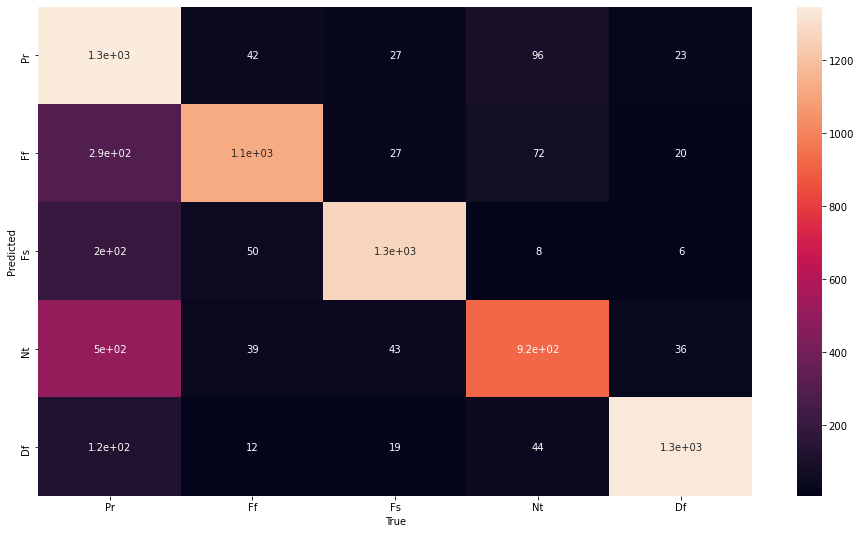

In [17]:
fig, ax = plt.subplots(figsize=(16,9));
ax = sns.heatmap(cm, xticklabels = ['Pr', 'Ff', 'Fs', 'Nt', 'Df'], yticklabels = ['Pr', 'Ff', 'Fs', 'Nt', 'Df'], annot = True);
ax.set(xlabel = 'True', ylabel = 'Predicted');